In [2]:
from keras.datasets import boston_housing
## 본 분석과 별로로 진행하므로 과제에 주어진 데이터셋 대신 keras에서 데이터 임포트
from sklearn.preprocessing import StandardScaler
from keras import models, layers
import numpy as np

In [3]:
(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

In [4]:
train_data.shape

(404, 13)

In [5]:
test_data.shape

(102, 13)

In [6]:
print(train_data[0], train_targets[0])

[  1.23247   0.        8.14      0.        0.538     6.142    91.7
   3.9769    4.      307.       21.      396.9      18.72   ] 15.2


In [7]:
train_targets # array

array([15.2, 42.3, 50. , 21.1, 17.7, 18.5, 11.3, 15.6, 15.6, 14.4, 12.1,
       17.9, 23.1, 19.9, 15.7,  8.8, 50. , 22.5, 24.1, 27.5, 10.9, 30.8,
       32.9, 24. , 18.5, 13.3, 22.9, 34.7, 16.6, 17.5, 22.3, 16.1, 14.9,
       23.1, 34.9, 25. , 13.9, 13.1, 20.4, 20. , 15.2, 24.7, 22.2, 16.7,
       12.7, 15.6, 18.4, 21. , 30.1, 15.1, 18.7,  9.6, 31.5, 24.8, 19.1,
       22. , 14.5, 11. , 32. , 29.4, 20.3, 24.4, 14.6, 19.5, 14.1, 14.3,
       15.6, 10.5,  6.3, 19.3, 19.3, 13.4, 36.4, 17.8, 13.5, 16.5,  8.3,
       14.3, 16. , 13.4, 28.6, 43.5, 20.2, 22. , 23. , 20.7, 12.5, 48.5,
       14.6, 13.4, 23.7, 50. , 21.7, 39.8, 38.7, 22.2, 34.9, 22.5, 31.1,
       28.7, 46. , 41.7, 21. , 26.6, 15. , 24.4, 13.3, 21.2, 11.7, 21.7,
       19.4, 50. , 22.8, 19.7, 24.7, 36.2, 14.2, 18.9, 18.3, 20.6, 24.6,
       18.2,  8.7, 44. , 10.4, 13.2, 21.2, 37. , 30.7, 22.9, 20. , 19.3,
       31.7, 32. , 23.1, 18.8, 10.9, 50. , 19.6,  5. , 14.4, 19.8, 13.8,
       19.6, 23.9, 24.5, 25. , 19.9, 17.2, 24.6, 13

- 데이터 정규화

In [8]:
mean = train_data.mean(axis=0)

train_data -= mean
std = train_data.std(axis=0)
train_data /= std
                    
test_data -= mean
test_data /= std

- 모델 정의

64개의 유닛을 가진 2개의 은닉층으로 네트워크 구성, 활성화 함수로 ReLU, 손실함수로 MSE 사용

In [9]:
def build_model():
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu', input_shape=(train_data.shape[1],)))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1)) # 선형 층
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    return model

- 훈련 검증 : K-fold cross-validation

In [48]:
k = 5

num_val_samples = len(train_data) // k

num_epochs = 100
all_scores = []

for i in range(k):
    print('처리중인 폴드 #', i)
    # 검증 데이터 준비 : k번째 분할
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
    
    # 훈련 데이터 준비 : 다른 분할 전체
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
        train_data[(i+1) * num_val_samples:]], 
        axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
        train_targets[(i+1) * num_val_samples:]], 
        axis=0)
    
    # 케라스 모델 구성
    model = build_model()
    model.fit(partial_train_data, partial_train_targets,
             epochs=num_epochs, batch_size=1, verbose=0)
    # 모델 평가
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
    all_scores.append(val_mae)

처리중인 폴드 # 0
처리중인 폴드 # 1
처리중인 폴드 # 2
처리중인 폴드 # 3
처리중인 폴드 # 4


In [49]:
all_scores

[2.08777117729187,
 2.8112411499023438,
 2.2085742950439453,
 2.6834003925323486,
 2.807884931564331]

In [50]:
np.mean(all_scores)

2.519774389266968

주택 가격이 1만 ~ 5만달러 범위인데 예측의 차이가 2500달러면 비교적 큰 수준.
> 모델의 성능이 좋지 않음

- 성능 개선을 위해 좀더 오래 훈련(epoch = 500)

In [52]:
num_epochs = 500
all_mae_histories = []

for i in range(k):
    print('처리중인 폴드 #', i)
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
    
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
        train_data[(i+1) * num_val_samples:]], 
        axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
        train_targets[(i+1) * num_val_samples:]], 
        axis=0)
    
    model = build_model()
    history = model.fit(partial_train_data, partial_train_targets,
                        validation_data=(val_data, val_targets),
                        epochs=num_epochs, batch_size=1, verbose=0)
    
    mae_history = history.history['val_mae']
    all_mae_histories.append(mae_history)

처리중인 폴드 # 0
처리중인 폴드 # 1
처리중인 폴드 # 2
처리중인 폴드 # 3
처리중인 폴드 # 4


- 모든 폴드에 대해 epoch의 MAE 점수 평균 계산

In [53]:
average_mae_history = [np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

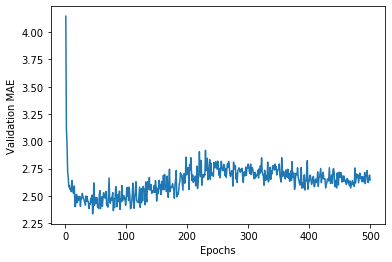

In [54]:
import matplotlib.pyplot as plt

plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

학습 초반의 데이터 포인트 제거, 각 포인트를 이전 포인트의 지수 이동 평균으로 대체

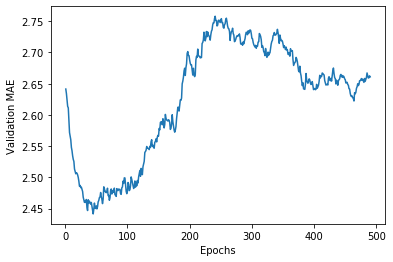

In [55]:
def smooth_curve(points, factor=0.9):
    smoothed_points = []
    
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

smooth_mae_history = smooth_curve(average_mae_history[10:])

plt.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

epoch = 80일때 MAE 최소, 이후로는 과적합

- 최종 모델로 훈련한 후 성능 확인

In [56]:
model = build_model()
model.fit(train_data, train_targets,
         epochs=80, batch_size=16, verbose=0)

test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)

102/102 [==============================] - 0s 1ms/step


In [57]:
test_mae_score

2.649771213531494

성능의 향상이 관찰되지 않음

#### 검토 : 단순한 데이터를 딥러닝 모형으로 적합시키는 경우, 계산량 및 시간 대비 뚜렷한 개선이 관찰되지 않으므로 도입 실익이 없다